In [1]:
#@title Click Headers
from IPython.display import HTML,display
import random
def clickh(string,emo='✒️'):
    font_color_set=['#E91E63','#FA7A00','#FED85D','#91E351',
                    '#00D8A0','#1AADE0','#3355FF','#7855EE']
    font_family_set=['times','courier']
    font_size_set=list(range(20,28,1))
    html_str="""
    <p class='click_header' 
    onclick='setStyle(this,
        &#34;"""+random.choice(font_color_set)+"""&#34;,
        &#34;"""+random.choice(font_family_set)+"""&#34;,
        &#34;"""+str(random.choice(font_size_set))+"""&#34;)'
    style='text-shadow:3px 3px 3px #ccc; font-family:courier; 
    font-size:20px; color:#ff33ff;'>
    """+emo+"""  """+string+"""
    </p>
    <script>
    function setStyle(element,color,family,size) {
     var docs=document.getElementsByClassName('click_header');
     for (var i=0; i<docs.length; i++) {
         docs[i].style='text-shadow:3px 3px 3px slategray; '+
                       'font-family:'+family+
                       '; font-size:'+size+'px; '; 
         docs[i].style.color=color;}; };
    </"""+"""script>"""
    display(HTML(html_str))

In [2]:
clickh('Code Modules & Parameters')

In [3]:
import os,numpy as np,pandas as pd,pylab as pl
import h5py,urllib,torch,torchvision,tensorflow as tf
import tensorflow.keras.layers as tkl
from torch.utils.data import Dataset as tds,DataLoader as tdl
import torch.nn.functional as tnnf,torch.nn as tnn
from IPython.core.magic import register_line_magic
from IPython.display import HTML,display
dev=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
clickh('Data')

In [5]:
names=[['lowercase','uppercase'],
       [s for s in u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'],
       ['single-colored paper','striped paper','squared paper','graph paper']]
path='https://raw.githubusercontent.com/OlgaBelitskaya/data/main/zip_letters/'
def file_name(lower_upper,letter,background,names=names):
    file_pre='%02d_'%names[0].index(lower_upper)
    file_pre+='%02d_'%names[1].index(letter)
    file_pre+='%02d'%names[2].index(background)
    return file_pre+'.h5'
file_names=[file_name(n0,n1,n2) for n2 in names[2] 
            for n1 in names[1] for n0 in names[0]]
file_names=[file_names[2*i] for i in range(9)]; file_names

['00_00_00.h5',
 '00_01_00.h5',
 '00_02_00.h5',
 '00_03_00.h5',
 '00_04_00.h5',
 '00_05_00.h5',
 '00_06_00.h5',
 '00_07_00.h5',
 '00_08_00.h5']

In [6]:
images,nlabels,labels=[],[],[]
for h5f in file_names:
    input_file=urllib.request.urlopen(path+h5f)
    output_file=open(h5f,'wb'); output_file.write(input_file.read())
    output_file.close(); input_file.close()
    with h5py.File(h5f,'r') as f:
        keys=list(f.keys()); nums=f[keys[0]].shape[0]
        print('file name: %s; '%h5f+'number of images: %d'%nums)
        images.append(np.array(f[keys[0]],dtype='float32'))
        nlabels=[el.decode('utf-8') for el in f[keys[1]]]
        labels.append(np.array(
            nums*[[names[i].index(nlabels[i]) 
                   for i in range(3)]],dtype='int32'))
        f.close(); os.remove(h5f)
images=np.concatenate(images,axis=0)
labels=np.concatenate(labels,axis=0)
images.shape,images.dtype,nlabels,labels.shape,labels.dtype

file name: 00_00_00.h5; number of images: 635
file name: 00_01_00.h5; number of images: 631
file name: 00_02_00.h5; number of images: 928
file name: 00_03_00.h5; number of images: 1006
file name: 00_04_00.h5; number of images: 907
file name: 00_05_00.h5; number of images: 1202
file name: 00_06_00.h5; number of images: 1013
file name: 00_07_00.h5; number of images: 887
file name: 00_08_00.h5; number of images: 948


((8157, 32, 32, 3),
 dtype('float32'),
 ['lowercase', 'з', 'single-colored paper'],
 (8157, 3),
 dtype('int32'))

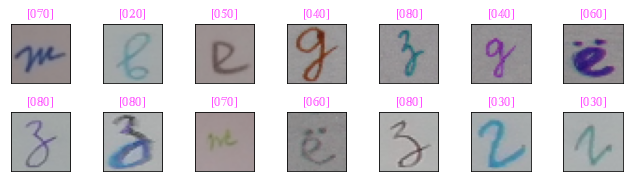

In [7]:
shuffle_ids=np.arange(images.shape[0])
np.random.RandomState(1234).shuffle(shuffle_ids)
images=images[shuffle_ids]
labels=labels[shuffle_ids]
def display_images(n_images,cols,images,labels):
    rows=n_images//cols    
    pl.figure(figsize=(1.3*cols,1.3*rows))
    for i in range(n_images):
        pl.subplot(rows,cols,i+1); pl.imshow(images[i])
        pl.title('$\\mathbb{'+str(labels[i])+'}$',color='#ff36ff')
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()
display_images(14,7,images,labels)

In [8]:
img_size=28; N=labels.shape[0]; n=int(.2*N)
x=tf.image.resize(images,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
x_test,x_train=x[:n],x[n:]
y_test,y_train=labels[:,1][:n],labels[:,1][n:]

(1, 28, 28) 0.590327716247335


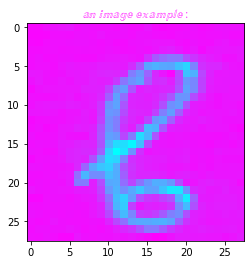

In [9]:
pl.imshow(x_test[1].reshape(img_size,img_size),cmap=pl.cm.cool)
pl.title('$\\mathbb{'+'an \\; image \\; example:'+'}$',color='#ff36ff')
print(x_test[1].shape,x_test.mean())

In [10]:
random_seed=23; batch_size=128
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
train=TData(x_train,y_train); test=TData(x_test,y_test)
train_loader=tdl(dataset=train,shuffle=True,batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False,batch_size=batch_size)

image dimensions: torch.Size([128, 1, 28, 28])
label dimensions: torch.Size([128])


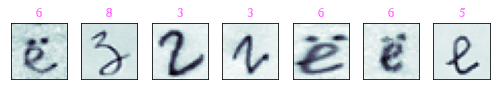

In [11]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader
    if n=='2': data_loader=test_loader
    for images,labels in data_loader:  
        print('image dimensions: %s'%str(images.shape))
        print('label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(7,2))
        for i in range(n,n+7):
            ax=fig.add_subplot(1,7,i-n+1,xticks=[],yticks=[])
            ax.set_title(
                '$\\mathbb{'+str(labels[i].item())+'}$',color='#ff36ff')
            ax.imshow(
                (images[i]).reshape(img_size,img_size),cmap=pl.cm.bone)
        pl.tight_layout(); pl.show(); break
%display_examples 2

In [12]:
seed_size2=16; noise_dim2=256; img_size2=42
epochs=150; buffer_size2=11000; batch_size2=128
norm_img=tf.random.normal([1,noise_dim2])
seed_imgs=tf.random.normal([seed_size2,noise_dim2])

In [13]:
x=tf.image.resize(255*images,[img_size2,img_size2]).numpy()
x=tf.image.rgb_to_grayscale(x).numpy()
x=np.array(x.reshape(-1,img_size2,img_size2,1),dtype='float32')

(42, 42, 1) 150.47523


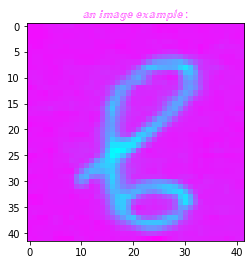

In [14]:
pl.imshow(x[1].reshape(img_size2,img_size2),cmap=pl.cm.cool)
pl.title('$\\mathbb{'+'an \\; image \\; example:'+'}$',color='#ff36ff')
print(x[1].shape,x.mean())

In [15]:
x=(127.5-x)/127.5
letters=tf.data.Dataset.from_tensor_slices(x)\
.shuffle(buffer_size2).batch(batch_size2)

(42, 42, 1) -0.18019868


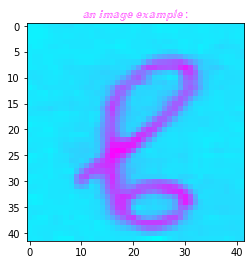

In [16]:
pl.imshow(x[1].reshape(img_size2,img_size2),cmap=pl.cm.cool)
pl.title('$\\mathbb{'+'an \\; image \\; example:'+'}$',color='#ff36ff')
print(x[1].shape,x.mean())

In [17]:
clickh('Pytorch Autoencoders')

In [18]:
ch1,ch2,ch3=16,48,144
def to_onehot(labels,num_classes,device):
    labels_ohe=torch.zeros(labels.size()[0],num_classes).to(device)
    labels_ohe.scatter_(1,labels.view(-1,1),1)
    return labels_ohe
class CondVarAE(tnn.Module):
    def __init__(self,num_features,num_latent,num_classes):
        super(CondVarAE,self).__init__()
        self.num_classes=num_classes
        # ENCODER
        self.conv_en1=tnn.Conv2d(
            in_channels=1+self.num_classes,out_channels=ch1,
            kernel_size=(6,6),stride=(2,2),padding=0)
        self.conv_en2=tnn.Conv2d(
            in_channels=ch1,out_channels=ch2,
            kernel_size=(4,4),stride=(2,2),padding=0)                        
        self.conv_en3=tnn.Conv2d(
            in_channels=ch2,out_channels=ch3,
            kernel_size=(2,2),stride=(2,2),padding=0)                     
        self.z_mean=tnn.Linear(ch3*2*2,num_latent)
        self.z_log_var=tnn.Linear(ch3*2*2,num_latent)
        # DECODER
        self.linear_de1=tnn.Linear(num_latent+self.num_classes,ch3*2*2)
        self.deconv_de1=tnn.ConvTranspose2d(
            in_channels=ch3,out_channels=ch2,
            kernel_size=(2,2),stride=(2,2),padding=0)                             
        self.deconv_de2=tnn.ConvTranspose2d(
            in_channels=ch2,out_channels=ch1,
            kernel_size=(4,4),stride=(3,3),padding=1)       
        self.deconv_de3=tnn.ConvTranspose2d(
            in_channels=ch1,out_channels=1,
            kernel_size=(6,6),stride=(3,3),padding=4)        
    def reparameterize(self, z_mu, z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)  
    def encoder(self,features,targets):
        onehot_targets=to_onehot(targets,self.num_classes,dev)
        onehot_targets=onehot_targets.view(-1,self.num_classes,1,1)        
        ones=torch.ones(features.size()[0],self.num_classes,
                        features.size()[2],features.size()[3], 
                        dtype=features.dtype).to(dev)
        ones=ones*onehot_targets
        x=torch.cat((features,ones),dim=1)    
        x=self.conv_en1(x); x=tnnf.leaky_relu(x)      
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)     
        z_mean=self.z_mean(x.view(-1,ch3*2*2))
        z_log_var=self.z_log_var(x.view(-1,ch3*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)
        return z_mean,z_log_var,encoded
    def decoder(self,encoded,targets):
        onehot_targets=to_onehot(targets,self.num_classes,dev)
        encoded=torch.cat((encoded,onehot_targets),dim=1)       
        x=self.linear_de1(encoded)
        x=x.view(-1,ch3,2,2) 
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features,targets):      
        z_mean,z_log_var,encoded=self.encoder(features,targets)
        decoded=self.decoder(encoded,targets)     
        return z_mean,z_log_var,encoded,decoded

In [19]:
torch.manual_seed(random_seed)
learning_rate=.001; num_latent=121
num_classes=len(set(y_train))
model=CondVarAE(num_features=img_size**2,
                num_latent=num_latent,num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [20]:
epochs=300
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):
        features=features.to(dev); targets=targets.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features,targets.long())
        kl_divergence=\
        (.5*(z_mean**2+torch.exp(z_log_var)-z_log_var-1)).sum()
        pixelwise_bce=tnnf.binary_cross_entropy(
            decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids,len(train_loader),cost))

Epoch: 001/300 | Batch: 000/051 | Cost: 68625.8047
Epoch: 002/300 | Batch: 000/051 | Cost: 67361.0000
Epoch: 003/300 | Batch: 000/051 | Cost: 67415.5938
Epoch: 004/300 | Batch: 000/051 | Cost: 67097.1328
Epoch: 005/300 | Batch: 000/051 | Cost: 67331.1641
Epoch: 006/300 | Batch: 000/051 | Cost: 67182.1484
Epoch: 007/300 | Batch: 000/051 | Cost: 66886.8672
Epoch: 008/300 | Batch: 000/051 | Cost: 67079.7734
Epoch: 009/300 | Batch: 000/051 | Cost: 66947.2891
Epoch: 010/300 | Batch: 000/051 | Cost: 67113.2109
Epoch: 011/300 | Batch: 000/051 | Cost: 67026.6719
Epoch: 012/300 | Batch: 000/051 | Cost: 66955.9766
Epoch: 013/300 | Batch: 000/051 | Cost: 66649.1562
Epoch: 014/300 | Batch: 000/051 | Cost: 66910.0469
Epoch: 015/300 | Batch: 000/051 | Cost: 66903.3906
Epoch: 016/300 | Batch: 000/051 | Cost: 67013.6875
Epoch: 017/300 | Batch: 000/051 | Cost: 66747.5156
Epoch: 018/300 | Batch: 000/051 | Cost: 67138.3438
Epoch: 019/300 | Batch: 000/051 | Cost: 66859.9609
Epoch: 020/300 | Batch: 000/051

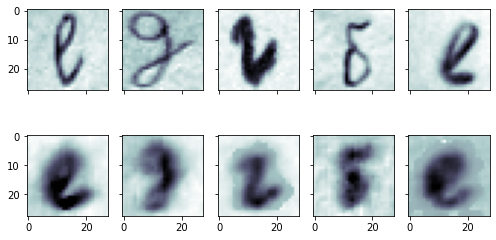

In [21]:
num_images=5
fig,axes=pl.subplots(
    nrows=2,ncols=num_images,
    sharex=True,sharey=True,figsize=(7,4))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')
pl.tight_layout(); pl.show()

In [22]:
@register_line_magic
def display_gen(l):
    l=int(l); num_images=5
    labels=torch.tensor([l]*num_images).to(dev)
    latent_features=torch.randn(num_images,num_latent).to(dev)
    generated_images=model.decoder(latent_features,labels)
    decoded_images=generated_images[:num_images]
    fig,axes=pl.subplots(nrows=1,ncols=num_images,
                         figsize=(7,2),sharey=True)
    for ax,img in zip(axes,decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu'))\
                  .reshape((img_size,img_size)),cmap='bone')
    pl.tight_layout(); pl.show()

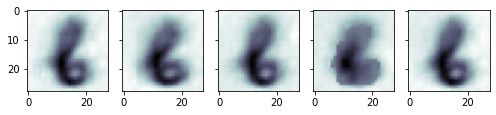

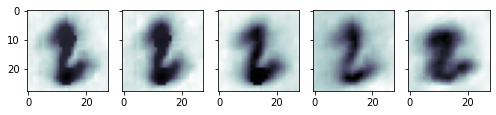

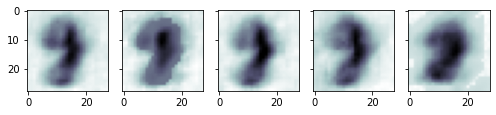

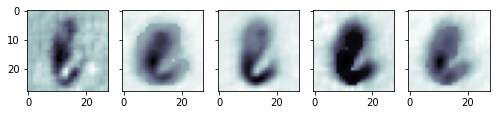

In [23]:
%display_gen 2
%display_gen 3
%display_gen 4
%display_gen 5

In [24]:
clickh('Keras DCGAN')

In [25]:
def tfgenerator():
    model=tf.keras.Sequential()
    model.add(tkl.Dense(
        7*7*256,use_bias=False,input_shape=(noise_dim2,)))
    model.add(tkl.BatchNormalization())
    model.add(tkl.LeakyReLU())
    model.add(tkl.Reshape((7,7,256)))
    model.add(tkl.Conv2DTranspose(
        256,(7,7),strides=(3,3),
        padding='same',use_bias=False))
    model.add(tkl.BatchNormalization())
    model.add(tkl.LeakyReLU())
    model.add(tkl.Conv2DTranspose(
        32,(7,7),strides=(2,2),
        padding='same',use_bias=False))
    model.add(tkl.BatchNormalization())
    model.add(tkl.LeakyReLU())
    model.add(tkl.Conv2DTranspose(
        1,(7,7),strides=(1,1),padding='same',
        use_bias=False,activation='tanh'))
    return model
tfgenerator=tfgenerator()

In [26]:
def tfdiscriminator():
    model=tf.keras.Sequential()
    model.add(tkl.Conv2D(
        32,(7,7),strides=(2,2),padding='same',
        input_shape=[img_size2,img_size2,1]))
    model.add(tkl.LeakyReLU())
    model.add(tkl.Dropout(.2))
    model.add(tkl.Conv2D(
        256,(7,7),strides=(2,2),padding='same'))
    model.add(tkl.LeakyReLU())
    model.add(tkl.Dropout(.2))
    model.add(tkl.Flatten())
    model.add(tkl.Dense(1))
    return model
tfdiscriminator=tfdiscriminator()

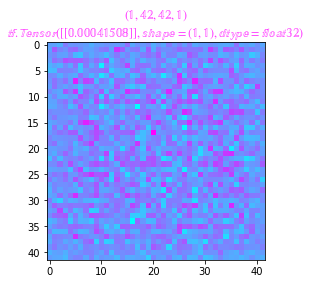

In [27]:
generated_img=tfgenerator(norm_img,training=False)
pl.imshow(generated_img[0,:,:,0],cmap=pl.cm.cool)
pl.title('$\\mathbb{'+str(generated_img.shape)+'}$'+'\n'+\
         '$\\mathbb{'+str(tfdiscriminator(generated_img))+'}$',
         color='#ff36ff');

In [28]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
generator_optimizer=tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-3)

In [29]:
@tf.function
def train_step(imgs):
    random_imgs=tf.random.normal([batch_size2,noise_dim2])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_imgs=tfgenerator(random_imgs,training=True)
        real_output=tfdiscriminator(imgs,training=True)
        fake_output=tfdiscriminator(generated_imgs,training=True)
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
        gradients_of_generator=\
        gen_tape.gradient(gen_loss,tfgenerator.trainable_variables)
        gradients_of_discriminator=\
        disc_tape.gradient(disc_loss,tfdiscriminator.trainable_variables)
        generator_optimizer\
        .apply_gradients(zip(gradients_of_generator,
                             tfgenerator.trainable_variables))
        discriminator_optimizer\
        .apply_gradients(zip(gradients_of_discriminator,
                             tfdiscriminator.trainable_variables))

In [30]:
def generate_images(model,epoch,test_input):
    predictions=model(test_input,training=False)
    fig=pl.figure(figsize=(6,6))
    for i in range(predictions.shape[0]):
        pl.subplot(4,4,i+1)
        pl.imshow(predictions[i,:,:,0]*127.5-127.5,cmap=pl.cm.bone)
        pl.axis('off')
    pl.savefig('epoch_{:04d}.png'.format(epoch+1))
    pl.suptitle('$\\mathbb{'+'epoch: \\; %04d'%(epoch+1)+'}$',color='#ff36ff')
    pl.show()

In [31]:
def train(data,epochs):
    for epoch in range(epochs):
        for image_batch in data:
            train_step(image_batch)
        if (epoch+1)%30==0:
            generate_images(tfgenerator,epoch,seed_imgs)

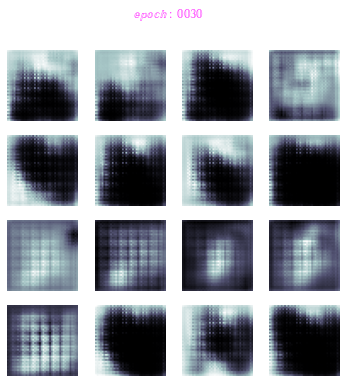

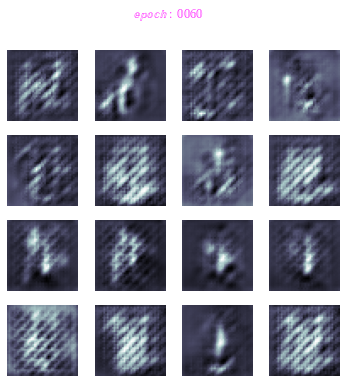

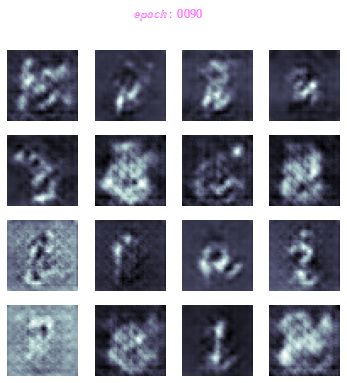

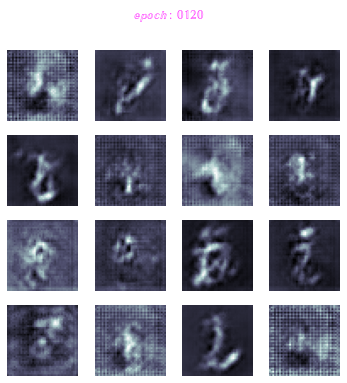

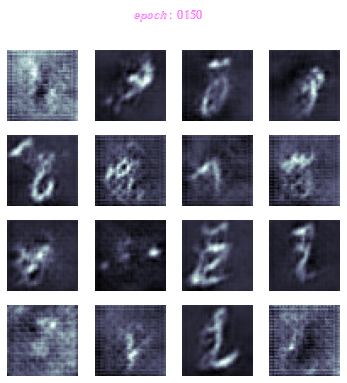

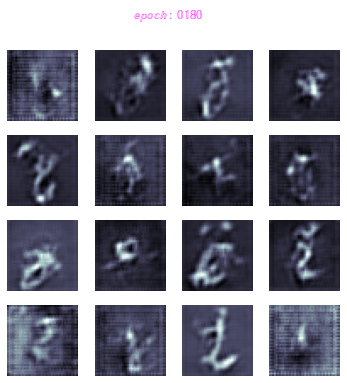

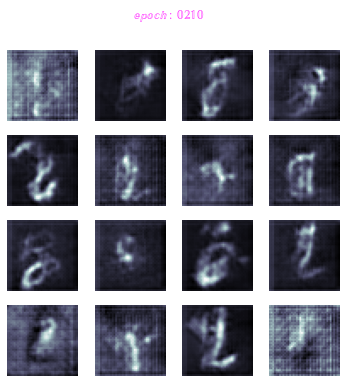

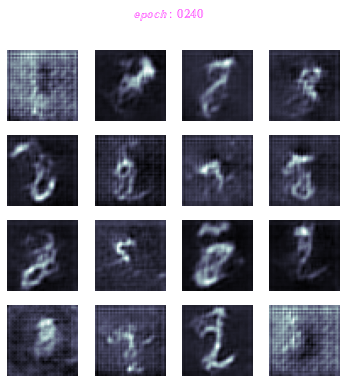

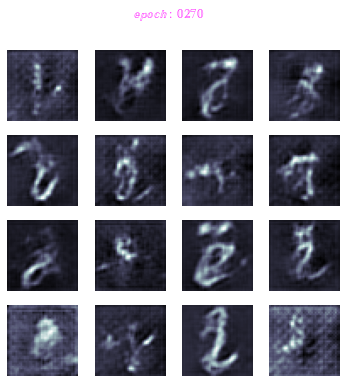

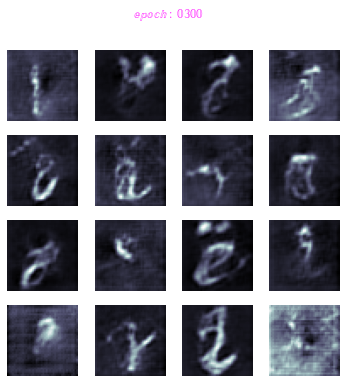

In [32]:
train(letters,epochs)